# Exploring Autofluorescence and Delta Distributions

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [ ]:
import sys 
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import glob
import altair as alt
import altair_catplot as altcat
import matplotlib.pyplot as plt
import act.viz
import pystan
import bebi103.viz
import bokeh.io
colors = act.viz.personal_style()
alt.renderers.enable('json')

%load_ext stanmagic
bokeh.io.output_notebook()

In [ ]:
# Load all simple and wt flow settings. 
simple_delta_files = glob.glob('../../data/flow/csv/*27yfp*delta*.csv')
simple_auto_files = glob.glob('../../data/flow/csv/*27yfp*auto*.csv')
dfs = []
for d, a in zip(simple_delta_files, simple_auto_files):
    d_date = d.split('/')[-1].split('_')[0]
    a_date = a.split('/')[-1].split('_')[0]
    d_df = pd.read_csv(d)[['gate','FITC-H']]
    a_df = pd.read_csv(a)[['FITC-H', 'gate']]
    d_df['date'] = d_date
    d_df['strain'] = 'delta'
    a_df['date'] = a_date
    a_df['strain'] = 'auto'
    dfs.append(d_df)
    dfs.append(a_df)
simple_df = pd.concat(dfs)

In [ ]:
fig, ax = plt.subplots(1, 1)
_colors = {'auto':'black',
           'delta':'tomato'}

for g, d in simple_df.groupby(['date', 'strain']):
    _d = d[d['gate']==1].copy()
    x = np.sort(d['FITC-H'])
    y = np.linspace(0, 1, len(d))
    ax.step(x, y, color=_colors[g[1]], lw=1) 
    
ax.set_xscale('log')
ax.set_xlim([1E2, 1E3])

In [ ]:
means = simple_df[simple_df['gate']==1].groupby(['date', 'strain'])['FITC-H'].mean().reset_index()
means

In [ ]:
grouped =  simple_df[simple_df['gate']==1].groupby(['date', 'strain'])['FITC-H'].mean().reset_index()




In [ ]:
(recording)[l]

In [ ]:
%%stan -v hier_model
data {
    int<lower=0> N;
    real<lower=0> mean_auto[N];
    real<lower=0> mean_delta[N];
}

parameters {
    real<lower=0> mu_auto;
    real<lower=0> mu_delta;
    real<lower=0> sigma;
}

model {
    mu_auto ~ lognormal(2, 2);
    mu_delta ~ lognormal(2, 2);
    sigma ~ normal(0, 10);
    
    for (i in 1:N) {
        mean_auto ~ normal(mu_auto, sigma);
        mean_delta ~ normal(mu_delta, sigma);
    }
}


In [ ]:
model = pystan.StanModel(model_code=hier_model.model_code)

In [ ]:
data_dict = {'N': len(simple_df['date'].unique()),
             'mean_auto': grouped[grouped['strain']=='auto']['FITC-H'], 
             'mean_delta':  grouped[grouped['strain']=='delta']['FITC-H']}
samples = model.sampling(data_dict)
samples_df = samples.to_dataframe()

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(samples_df['mu_auto'], bins=50, label='auto', 
           density=True, histtype='stepfilled', alpha=0.5)
ax.hist(samples_df['mu_delta'], bins=50, label='delta',
           density=True, histtype='stepfilled', alpha=0.5)
plt.legend()

In [ ]:
plt.plot(samples_df['mu_auto'], samples_df['sigma'], '.', color='black', alpha=0.5)
plt.plot(samples_df['mu_delta'], samples_df['sigma'], '.', color='tomato', alpha=0.5)

## Computing hierarchical fold-change 

In [124]:
%%stan -v fc_hier
data {
    int<lower=0> N_auto; // Total number of measurements
    int<lower=0> N_delta;
    int<lower=0> N;
    int<lower=0> J; // Total number of concentrations
    int<lower=0, upper=J> idx[N]; 
    vector<lower=0>[N]  means;  
    vector<lower=0>[N_auto] autofl;
    vector<lower=0>[N_delta] delta;
}

parameters {
    real<lower=0> mu_auto;
    real mu_delta;
    real<lower=0> sigma_auto;
    real<lower=0> sigma_delta;
    vector[J] mu;
    real<lower=0> sigma[J];
    
}

model {
    mu ~ normal(1000, 100);
    mu_auto ~ lognormal(2, 2);
    mu_delta ~ normal(1000, 100);
    sigma_auto ~ normal(0, 10);
    sigma_delta ~ normal(0, 10);
    sigma ~ normal(0, 10);
    autofl ~ normal(mu_auto, sigma_auto);
    delta ~ normal(mu_delta + mu_auto, sigma_delta);
    for (i in 1:N) {
        means[i] ~ normal(mu[idx[i]] + mu_auto, sigma[idx[i]]);
    }
}

generated quantities {
    real fold_change[J];
    for (i in 1:J) {
        fold_change[i] = mu[i] / mu_delta;
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in fc_hier object.
Type fc_hier in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^
Access model compile output properties
fc_hier.model_file -> Name of stan_file [None]
fc_hier.model_name -> Name of stan model [None]
fc_hier.model_code -> Model code [data {     int<lower ....]


In [ ]:
model = pystan.StanModel(model_code=fc_hier.model_code)

In [133]:
# Load the data sets. 
data = pd.concat([pd.read_csv(f) for f in glob.glob('../processing/*27yfp*xan*/output/*fold_change*.csv')])
data = data[['date', 'promoter', 'strain', 'xan_mgml', 'mean_FITC']]

In [134]:
idx = data.groupby(['xan_mgml']).ngroup() + 1
data['idx'] = idx
xan_concs = {i:x for i, x in zip(data[data['strain']=='dilution']['idx'],
                                 data[data['strain']=='dilution']['xan_mgml'])}



In [135]:
data_dict = {'N':len(data[data['strain']=='dilution']), 
             'N_auto': len(data[data['strain']=='auto']),
             'N_delta': len(data[data['strain']=='delta']),
             'autofl': data[data['strain']=='auto']['mean_FITC'],
             'delta': data[data['strain']=='delta']['mean_FITC'],
             'J':data['idx'].max(),
             'idx':data[data['strain']=='dilution']['idx'].astype(int), 
             'means':data[data['strain']=='dilution']['mean_FITC']}
samples = model.sampling(data_dict, iter=10000, control=dict(adapt_delta=0.95))

In [136]:
samples

Inference for Stan model: anon_model_085f0d2e54aecbdaf4d1be439aee34a1.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_auto         8199.0    1.01   88.8 8024.7 8140.6 8198.4 8258.2 8373.0   7658    1.0
mu_delta         -1835    0.67  100.3  -2032  -1902  -1834  -1767  -1639  22590    1.0
sigma_auto      463.42    0.05   5.66 452.34 459.57 463.44 467.21 474.34  15540    1.0
sigma_delta     403.12    0.06    6.8 389.77 398.53 403.05 407.72 416.57  14393    1.0
mu[1]            -1835    0.66 100.15  -2033  -1902  -1834  -1768  -1637  23089    1.0
mu[2]            -1454    0.66  99.16  -1648  -1521  -1453  -1388  -1260  22733    1.0
mu[3]            -1835    0.67 100.39  -2033  -1904  -1834  -1767  -1639  22189    1.0
mu[4]            -1442    0.66  99.53  -1636  -1510  -1443  -1375  -1245  23012    1.0
mu[5]            -1596    

In [130]:
xan_concs

{7: 1.0,
 3: 0.1,
 13: 4.0,
 12: 3.5,
 11: 3.0,
 2: 0.05,
 10: 2.5,
 5: 0.5,
 6: 0.75,
 8: 1.5,
 4: 0.25,
 1: 0.0,
 9: 2.0,
 17: 8.0,
 14: 5.0,
 16: 7.0,
 18: 10.0,
 15: 6.0}

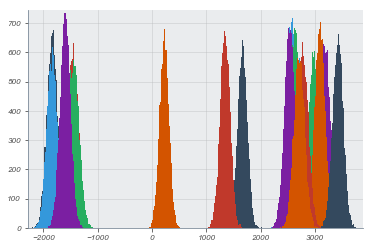

In [131]:
samples_df = samples.to_dataframe()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
bins = np.logspace(1, 5, 200)

for i in range(data['idx'].max()):
    ax.hist(samples_df[f'mu[{i+1}]'], bins=100)


(array([  1.,   1.,   2.,   1.,   1.,   2.,   4.,   7.,   9.,  10.,  15.,
         30.,  36.,  39.,  52.,  59.,  79.,  95., 117., 157., 175., 181.,
        238., 309., 307., 390., 417., 451., 564., 575., 609., 654., 718.,
        737., 778., 809., 774., 843., 771., 824., 775., 757., 687., 700.,
        637., 585., 548., 492., 420., 414., 371., 281., 242., 212., 219.,
        144., 150., 115.,  74.,  82.,  68.,  46.,  35.,  25.,  22.,  10.,
         17.,   5.,  12.,   4.,   5.,   2.,   1.,   1.,   1.]),
 array([7862.48832857, 7871.43489099, 7880.3814534 , 7889.32801581,
        7898.27457822, 7907.22114063, 7916.16770304, 7925.11426545,
        7934.06082786, 7943.00739027, 7951.95395268, 7960.90051509,
        7969.8470775 , 7978.79363992, 7987.74020233, 7996.68676474,
        8005.63332715, 8014.57988956, 8023.52645197, 8032.47301438,
        8041.41957679, 8050.3661392 , 8059.31270161, 8068.25926402,
        8077.20582643, 8086.15238884, 8095.09895126, 8104.04551367,
        8112.992

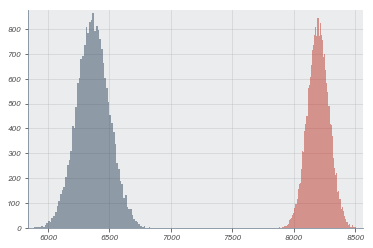

In [132]:
plt.hist(samples_df['mu_auto'] + samples_df['mu_delta'], bins=75, alpha=0.5)
plt.hist(samples_df['mu_auto'], bins=75, alpha=0.5)